In [1]:
import sys
sys.path.append('../')

import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from seirsplus.models import *
from network_utils import *
from stats_utils import *
from intervention_utils import *
import pickle as pkl

In [2]:
n_pop = 18700

# Grid info for isoboxes
dims_isoboxes = (29, 28)  # 812

# Grid info for tents
dims_block1 = (20, 67)  # 1340
dims_block2 = (53, 15)  # 795
dims_block3 = (19, 28)  # 532

# Isoboxes
pop_isoboxes = 8100
pop_per_isobox = 10
n_isoboxes = dims_isoboxes[0]*dims_isoboxes[1]

# Tents
n_tents = 2650
pop_tents = 10600
pop_per_tent = 4

# Others 
n_bathrooms = 144
n_ethnic_groups = 8

# We define neighboring structures within a range of 2 in the structure grid
proximity = 2

# Define the maximum population per structures (tents and isoboxes) drawn from a poisson distribution
max_pop_per_struct_isoboxes = list(poisson.rvs(mu=pop_per_isobox, size=n_isoboxes))
max_pop_per_struct_block1 = list(poisson.rvs(mu=pop_per_tent, size=dims_block1[0]*dims_block1[1]))
max_pop_per_struct_block2 = list(poisson.rvs(mu=pop_per_tent, size=dims_block2[0]*dims_block2[1]))
max_pop_per_struct_block3 = list(poisson.rvs(mu=pop_per_tent, size=dims_block3[0]*dims_block3[1]))

max_pop_per_struct = max_pop_per_struct_isoboxes\
                     + max_pop_per_struct_block1\
                     + max_pop_per_struct_block2\
                     + max_pop_per_struct_block3

n_structs = len(max_pop_per_struct)

# Sample the population age, and parameter rates
sample_pop = sample_population(n_pop, "data/augmented_population.csv")

In [16]:
household_weight = 0.98  # Edge weight for connections within each structure
graph, nodes_per_struct = create_graph(n_structs, 0, n_pop, max_pop_per_struct, 
                                       edge_weight=household_weight, label="household",
                                       age_list=list(sample_pop["age"]),
                                       sex_list = list(sample_pop["sex"]),
                                       n_ethnicities=n_ethnic_groups)

100%|██████████| 18700/18700 [00:04<00:00, 3902.69it/s]


In [18]:
grid_isoboxes = create_grid(dims_isoboxes[0], dims_isoboxes[1], 0)
grid_block1 = create_grid(dims_block1[0], dims_block1[1], grid_isoboxes[-1][-1] + 1)
grid_block2 = create_grid(dims_block2[0], dims_block2[1], grid_block1[-1][-1] + 1)
grid_block3 = create_grid(dims_block3[0], dims_block3[1], grid_block2[-1][-1] + 1)

In [19]:
neighbor_weight = 0.017
graph = connect_neighbors(graph, 0, n_isoboxes, nodes_per_struct,
                          grid_isoboxes, 2, neighbor_weight, 'friendship')
graph = connect_neighbors(graph, dims_isoboxes[0]*dims_isoboxes[1], dims_block1[0]*dims_block1[1], nodes_per_struct,
                          grid_block1, 2, neighbor_weight, 'friendship')
graph = connect_neighbors(graph, dims_block1[0]*dims_block1[1], dims_block2[0]*dims_block2[1], nodes_per_struct,
                          grid_block2, 2, neighbor_weight, 'friendship')
graph = connect_neighbors(graph, dims_block2[0]*dims_block2[1], dims_block3[0]*dims_block3[1], nodes_per_struct,
                          grid_block3, 2, neighbor_weight, 'friendship')

In [17]:
def save_graph(graph, nodes_per_struct, name):
    with open(name + ".graph", "wb") as f:
        pkl.dump(graph, f)
    
    with open(name + ".nps", "wb") as f:
        pkl.dump(nodes_per_struct, f)

def load_graph(name):
    with open(name + ".graph", "rb") as f:
        graph = pkl.load(f)
        
    with open(name + ".nps", "rb") as f:
        nodes_per_struct = pkl.load(f)
        
    return graph, nodes_per_struct

In [20]:
save_graph(graph, nodes_per_struct, "Moria_wNeighbors")

In [12]:
# Remove edges from graph: food

def remove_all_edges(base_graph, edge_label_list):
    graph = base_graph.copy()
    for node in graph:
        neighbors = [neighbor for neighbor in list(graph[node].keys())
                             if graph.edges[node, neighbor]["label"] in edge_label_list]

        for neighbor in neighbors:
            graph.remove_edge(node, neighbor)
        
    return graph

graph = remove_all_edges(graph, ["food"])

In [25]:
graph, nodes_per_struct = load_graph("Moria_wNeighbors")

In [27]:
def multiple_food_queues(base_graph, n_food_queues_per_block, food_weight, nodes_per_struct, grids):
    graph = base_graph.copy()
    for grid in grids:
        longest_axis = np.argmax(grid.shape)
        index_limit = grid.shape[longest_axis] // n_food_queues_per_block
        subgrids = []
        if not longest_axis:
            for i in range(n_food_queues_per_block):
                subgrids.append(grid[i * index_limit:(i + 1) * index_limit, :])
        else:
            for i in range(n_food_queues_per_block):
                subgrids.append(grid[:, i * index_limit:(i + 1) * index_limit])
        
        for i in range(len(subgrids)):
            subgrid = subgrids[i]
            nodes_per_struct_subgrid = [nodes_per_struct[subgrid[i][j]] for i in range(len(subgrid)) for j in range(len(subgrid[i]))]
            
            graph = connect_food_queue(graph, nodes_per_struct_subgrid, food_weight, "food_%i" % i)
    
    return graph

food_weight = 0.407
graph_1foodqueue = connect_food_queue(graph, nodes_per_struct, food_weight, "food")
graph_4foodqueues = multiple_food_queues(graph, 1, food_weight, nodes_per_struct, [grid_isoboxes, grid_block1, grid_block2, grid_block3])
graph_8foodqueues = multiple_food_queues(graph, 2, food_weight, nodes_per_struct, [grid_isoboxes, grid_block1, grid_block2, grid_block3])

In [28]:
household_weight = 0.98  # Edge weight for connections within each structure
neighbor_weight = 0.017
food_weight = 0.407 # Edge weight for connections in the food queue 

transmission_rate = 1.28
progression_rate = round(1/5.1, 3)
recovery_rate = 0.056 # Approx 1/18 -> Recovery occurs after 18 days
hosp_rate = round(1/11.4, 3) #1/6.3 # From Tucker Model
# crit_rate = 0.3 # From camp_params
crit_rate = list((sample_pop["death_rate"] / sample_pop["prob_symptomatic"]) / sample_pop["prob_hospitalisation"])
death_rate = 0.75


prob_global_contact = 1
prob_detected_global_contact = 1

# prob_hosp_to_critical = list(sample_pop["death_rate"]/sample_pop["prob_hospitalisation"])
prob_death = list(sample_pop["death_rate"])
prob_asymptomatic = list(1 - sample_pop["prob_symptomatic"])
prob_symp_to_hosp = list(sample_pop["prob_hospitalisation"])

init_symp_cases = 1
init_asymp_cases = 0

In [30]:
ref_model_1fq = SymptomaticSEIRSNetworkModel(G=graph_1foodqueue, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, 
                                         lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, p=prob_global_contact, a=prob_asymptomatic, f=0.75, 
                                         h=prob_symp_to_hosp, q=prob_detected_global_contact, initI_S=init_symp_cases, initI_A=init_asymp_cases, store_Xseries=True)

ref_model_4fq = SymptomaticSEIRSNetworkModel(G=graph_4foodqueues, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, 
                                         lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, p=prob_global_contact, a=prob_asymptomatic, f=0.75, 
                                         h=prob_symp_to_hosp, q=prob_detected_global_contact, initI_S=init_symp_cases, initI_A=init_asymp_cases, store_Xseries=True)

In [31]:
t_steps = 200
node_states, simulation_results = run_simulation(ref_model_1fq, t_steps)

  0%|          | 0/200 [00:00<?, ?it/s]

Running simulation for 200 steps...



100%|██████████| 200/200 [27:48<00:00,  8.34s/it] 


In [33]:
t_steps = 200
node_states_4fq, simulation_results_4fq = run_simulation(ref_model_4fq, t_steps)

  0%|          | 0/200 [00:00<?, ?it/s]

Running simulation for 200 steps...



100%|██████████| 200/200 [20:43<00:00,  6.22s/it] 


In [ ]:
output_df = results_to_df(simulation_results)

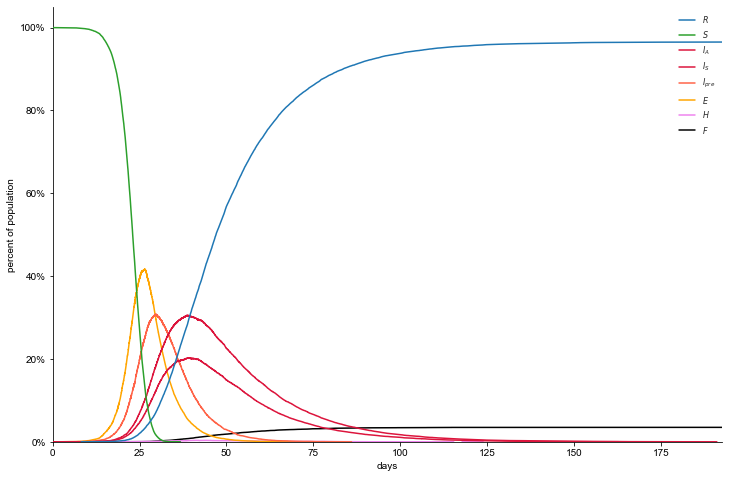

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc289c8d450>)

In [34]:
ref_model_1fq.figure_basic()

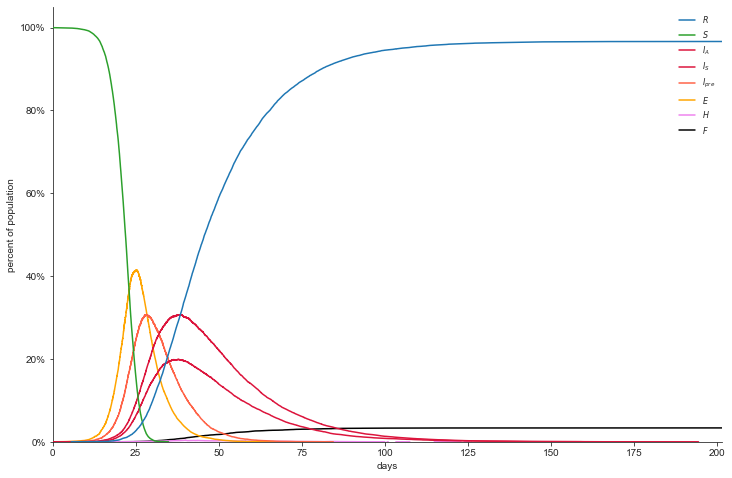

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc2b18aefd0>)

In [35]:
ref_model_4fq.figure_basic()

### Macrogrid

In [24]:
dims_macro_grid = (dims_block1[0] + dims_block2[0] + dims_block3[0], dims_block1[1])
macro_grid = np.ones(dims_macro_grid) * -1

for i in range(len(grid_block1)):
    for j in range(len(grid_block1[i])):
        macro_grid[i][j] = grid_block1[i][j]
        
for i in range(len(grid_block2)):
    for j in range(len(grid_block2[i])):
        macro_grid[i + dims_block1[0]][j + (dims_block1[1] - dims_block2[1] - dims_isoboxes[1])] = grid_block2[i][j]

for i in range(len(grid_isoboxes)):
    for j in range(len(grid_isoboxes[i])):
        macro_grid[i + dims_block1[0]][j + (dims_block1[1] - dims_isoboxes[1])] = grid_isoboxes[i][j]
        
for i in range(len(grid_block3)):
    for j in range(len(grid_block3[i])):
        macro_grid[i + dims_block1[0] + dims_block2[0]][j + (dims_block1[1] - dims_block3[1])] = grid_block3[i][j]